# Portfolio Ideas
A notebook to explore different investment portfolio ideas and compare their historic returns, inclusive of fees

In [61]:
%matplotlib inline

## Vanguard LifeStrategy 100%
First we just plot the price of the index over the maximum duration.

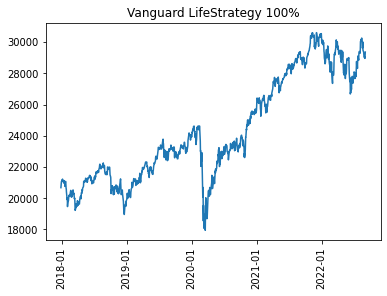

In [62]:
import yfinance as yf
import pendulum
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
price_history = yf.Ticker('0P0000TKZO.L').history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                  interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                  actions=False)
price_history = price_history[price_history['Close']>300]
plt.plot(price_history['Close'])
plt.xticks(rotation = 90)
plt.title('Vanguard LifeStrategy 100%')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))

Now we construct our investment scenario of a regular investment that maximises the UK ISA allowance.

In [ ]:
price_history['deposits']=[20000/365,]*len(price_history)
price_history.head()

In [ ]:
price_history['units'] = price_history['deposits']/price_history['Close']
price_history['cum_units'] = price_history['units'].cumsum()
price_history['cum_value'] =  price_history['cum_units']*price_history['Close']
price_history['fees'] = ((1+0.22/100)**(1/365)-1)*price_history['cum_value']

In [ ]:
plt.plot(price_history['cum_value']-price_history['fees'].cumsum())
plt.plot(price_history['deposits'].cumsum())
plt.xticks(rotation = 90)
plt.title('Vanguard LifeStrategy 100%')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))
profit = price_history.iloc[-1,price_history.columns.get_loc("cum_value")]-price_history['deposits'].sum()-price_history['fees'].sum()
print(profit)

# Portfolio Modelling
For portfolio analysis, I'd like to explore the following features:
* Modelling a porfolio consisting of multiple funds.
* Rebalancing to target allocations.
* Rebalancing at given frequency.
    
Proposed structure would be lists of fund names, tickers, allocations and ongoing charges. A deposit rate would also need to be defined. Rebalancing times could be specified as a date series.

Future functionality might include:
* Variable allocation.
* Definition of deposits in time.

In [97]:
funds = ["Scottish Mortgage Ord","Fundsmith Equity I Acc"];
tickers = ["GB00BLDYK618","GB00B41YBW71"]
allocation = [0.5, 0.5]
annual_deposit = 20000
rebalance_rate = "monthly"
product_cost = [0.66, 0.99]

# Create data frames for each allocation
price_history_list = list()
for i in range(len(funds)):
    price_history = yf.Ticker(tickers[i]).history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                  interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                  actions=False)
    price_history['deposits']=[annual_deposit/365*allocation[i],]*len(price_history)
    price_history['units'] = price_history['deposits']/price_history['Close']
    price_history['cum_units'] = price_history['units'].cumsum()
    price_history['cum_value'] =  price_history['cum_units']*price_history['Close']
    price_history_list.append(price_history)

# Trim price_history_list to earliest date in portfolio
# Start by finding the first date data was available for each portfolio
first_timestamp = list ()
for price_history in price_history_list:
    first_timestamp.append(price_history.index[1])
start_date = max(first_timestamp)
    
# Now trim data
for i in range(len(price_history_list)):
    price_history_list[i] = price_history_list[i][price_history_list[i].index >= start_date]

price_history_list[0].head()

# Rebalance
# Start by creating rebalance series
from datetime import datetime
import pandas as pd
rebalance_dates = pd.date_range(start_date,datetime.now(tz=None), freq='M')

# Find allocation of rebalance dates
for i_date in range(len(rebalance_dates)):
#for i_date in [0]:
    # Find current asset allocation
    value_breakdown = list()
    for i_fund in range(len(price_history_list)):
        price_history = price_history_list[i_fund]
        matching_row = price_history.index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
        value_breakdown.append(price_history.iloc[matching_row].loc['cum_value']) # Include fees here?
    
    print(value_breakdown)
    

    # Computer targer allocations based on asset weightings
    target_allocation = [allocation_fraction*sum(value_breakdown) for allocation_fraction in allocation]

    
    # Update units, cum_units and cum_value in light of the new breakdown
    for i_fund in range(len(price_history_list)):
        
        # Extract df of interest
        price_history = price_history_list[i_fund]
        
        # Find index locations for cells of interest
        matching_row = price_history.index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
        cum_value_idx = price_history.columns.get_loc("cum_value")
        units_idx = price_history.columns.get_loc("units")
        
        # Compute units deviation from the target
        units_delta = (price_history.iloc[matching_row,cum_value_idx] - target_allocation[i_fund])/price_history.iloc[matching_row]['Close']
        
        # Update units entry to match target allocation
        price_history.iloc[matching_row,units_idx] -= units_delta
        
        # Update remaining rows
        price_history['cum_units'] = price_history['units'].cumsum()
        price_history['cum_value'] =  price_history['cum_units']*price_history['Close']
        price_history['fees'] = ((1+product_cost[i_fund]/100)**(1/365)-1)*price_history['cum_value']
        
        # Update list with data frame including the new 
        price_history_list[i_fund] = price_history

[31408857.228515822, 606.3291997202998]
[-15841184.392968947, 15378290.114985485]
[-222615.18434755027, -220524.21586171456]
[-237226.5219643248, -228920.81458265655]
[-249874.89029293516, -246777.08019522394]
[-258323.6009129918, -253076.59006903743]
[-257278.0842211635, -261590.854463049]
[-270956.155367305, -266842.19130023225]
[-263553.98649854364, -268637.1591186009]
[-232767.6772054088, -249206.78667106706]
[-247773.5068508299, -248307.76863295483]
[-233307.8045977805, -230494.30518260095]
[-239579.29393059012, -241181.25329544433]
[-244876.48953317705, -250510.19415503892]
[-257202.24634875392, -262909.45197827276]
[-265608.39611581876, -264108.0444189927]
[-252966.3928893766, -267628.26235930435]
[-282386.34726431104, -272468.62808883504]
[-285714.4218612582, -289178.89873946225]
[-264924.6503881276, -285065.61074960197]
[-265706.9522764825, -265587.51645949855]
[-266054.90187333216, -258429.96437053866]
[-274582.9980469126, -267558.10509083234]
[-296105.8469406548, -271130.577

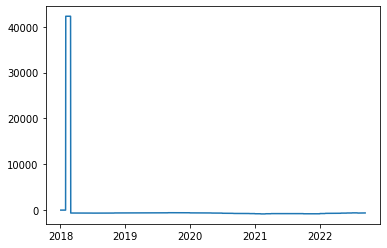

In [111]:
plt.plot(price_history_list[1].cum_units)

In [70]:
# Compute final value
price_history = price_history_list[0]
for i_fund in range(1,len(price_history_list)):
    price_history['cum_value'] += price_history_list[i_fund]['cum_value']
    price_history['fees'] += price_history_list[i_fund]['fees']
    price_history['deposits'] += price_history_list[i_fund]['deposits']
    
price_history.head()

,Open,High,Low,Close,Volume,deposits,units,cum_units,cum_value,fees
Date,,,,,,,,,,
2018-01-03,439.467470,447.297625,439.467470,446.710358,1664865,54.794521,0.061331,0.061331,54.794521,0.001233
2018-01-04,446.514614,451.212695,446.514614,450.625427,2309974,54.794521,0.060798,0.122129,110.033923,0.002476
2018-01-05,451.799965,453.953240,451.604200,452.191467,2721809,54.794521,0.060588,0.182717,165.426215,0.003724
2018-01-08,451.799996,457.476847,451.799996,456.498077,2239863,54.794521,0.060016,0.242733,221.507146,0.004985
2018-01-09,456.302329,460.804645,456.302329,460.217407,2563447,54.794521,0.059531,0.302264,277.306135,0.006237


-404397.9024003859


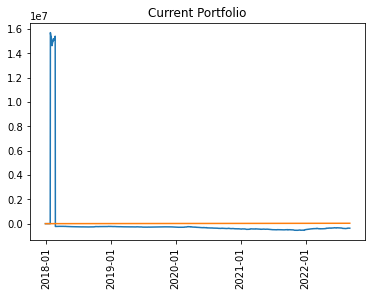

In [89]:
plt.plot(price_history['cum_value'])
plt.plot()
plt.plot(price_history['deposits'].cumsum())
plt.xticks(rotation = 90)
plt.title('Current Portfolio')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))
profit = price_history.iloc[-1,price_history.columns.get_loc("cum_value")]-price_history['deposits'].sum()-price_history['fees'].sum()
print(profit)